# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Finding** 
***

This project goal is to develop a pipeline to identify the lane boundaries in a real scenario. 

This is the advance version of the Finding Lane Lines on the Road project ([GitHub repository](https://github.com/rscova/CarND-LaneLines-P1))

The pipeline is based in 6 steps:
* 1. Camera Calibration
* 2. Distortion Image Correction
* 3. Color Spaces and Gradients Thresholds
* 4. Perspective transform (Bird's Eye)
* 5. Detect lane lines
* 6. Determine the lane curvature

So, in this jupyter notebook I am going to develop the pipeline step by step for one image, showing the results of each step to make easier to understand why I choose each method.


## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math, os, sys, glob
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Advanced Lane Finding Step By Step

**Test Images**


In [3]:
path_in = "test_images/"
path_out = "experiments/"
# Make a list of test images
img_names = os.listdir(path_in)

# Make a list of calibration images
cal_path = "camera_cal/"
img_calibration_paths = glob.glob(cal_path + "*.jpg")

print(img_names)
print(img_calibration_paths)

['challenge_video', 'harder_challenge_video', 'straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
['camera_cal/calibration1.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg']


### Step 1: Camera Calibration

**1.1 Extract object points and image points for camera calibration**

<Figure size 1080x1080 with 0 Axes>

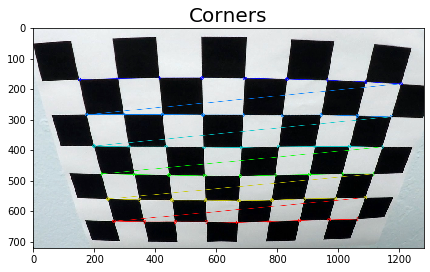

In [19]:
# prepare object points
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
plt.figure(figsize=(15,15))
for idx,img_cal in enumerate(img_calibration_paths):
    image = cv2.imread(img_cal)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if img_cal == 'camera_cal/calibration2.jpg':
            cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
            plt.figure(figsize=(7,7))
            plt.imshow(image)
            plt.title('Corners', fontsize=20)
        

 **1.2 Calibrate and calculate distortion coefficients**

Text(0.5, 1.0, 'Undistorted Image')

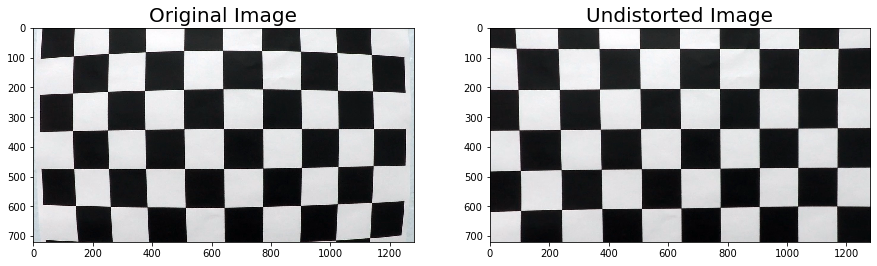

In [15]:
image = cv2.imread("camera_cal/calibration1.jpg")
img_size = (image.shape[1], image.shape[0])
imshape = image.shape

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

undist = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)


### Step 2: Distortion correction

Text(0.5, 1.0, 'Differences')

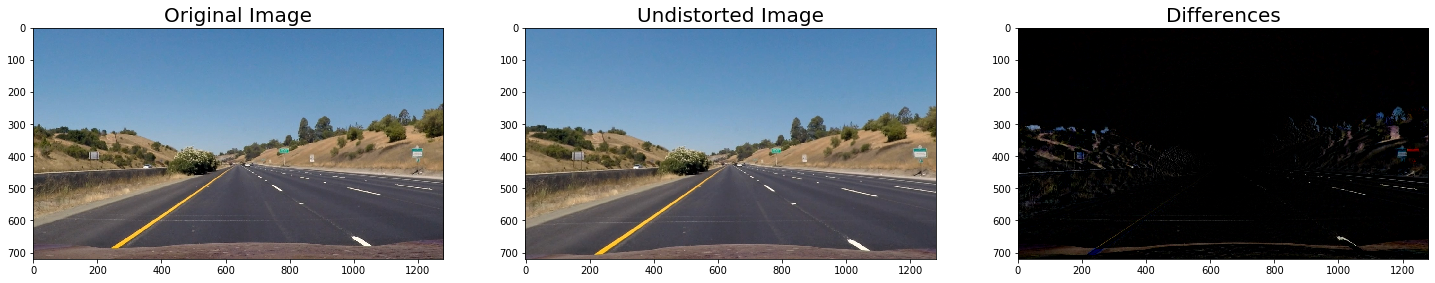

In [20]:
# Read Image
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
undist = cv2.undistort(image, mtx, dist, None, mtx) 

#Find differences 
difference = cv2.subtract(image, undist)

# Draw and display
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
ax3.imshow(difference)
ax3.set_title('Differences', fontsize=20)
    

### Step 3: Color Spaces and Gradients

**3.1 Color Spaces: RGB, HSV and HLS**

The channel S(HLS) and R(RGB) darkened, are the most suitable channels to detect lines. 

S detects a little bit better the yellow and white marks in different iluminations, but get less information than R dark.

Despite, R dark don't take acount the shadows, but it is work worst than S (sometimes) because detects more light.


Text(0.5, 1.0, 'Cb')

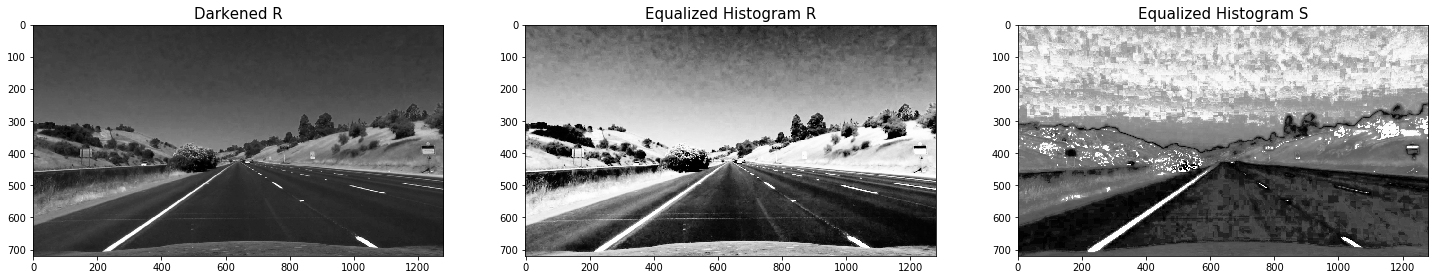

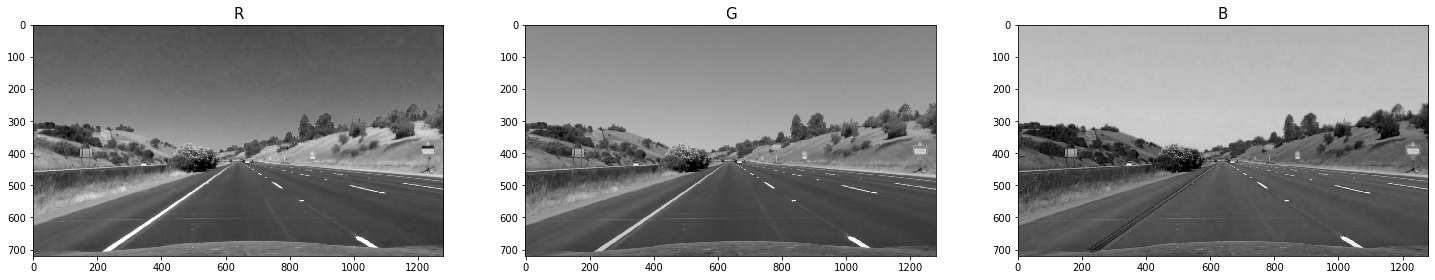

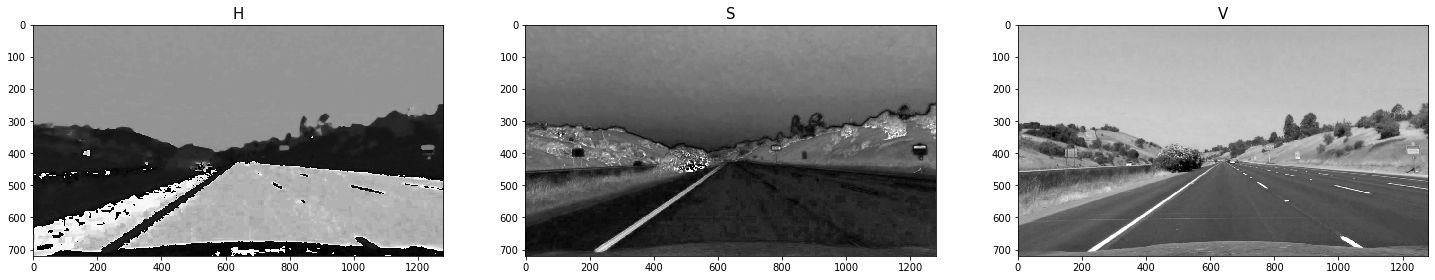

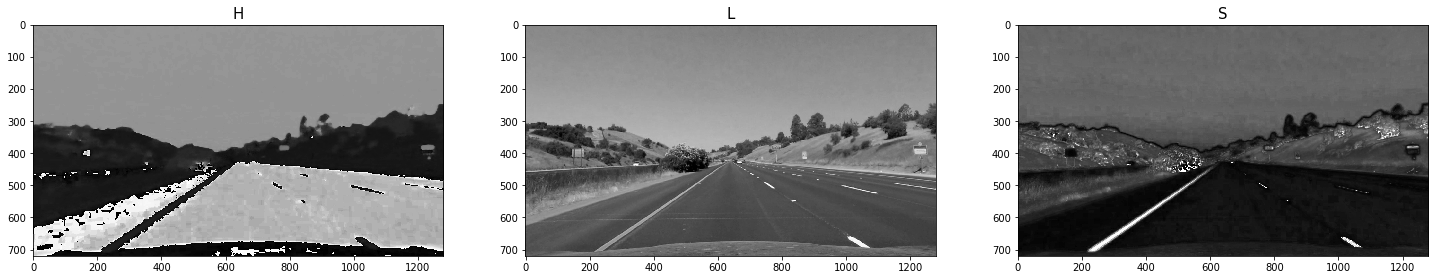

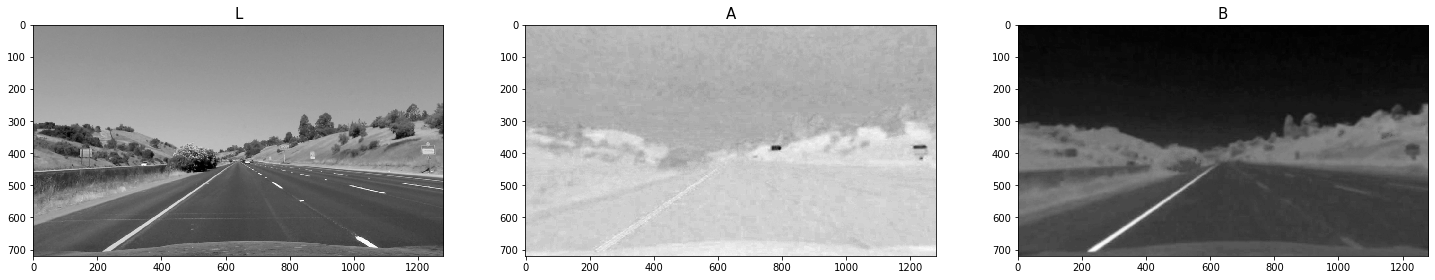

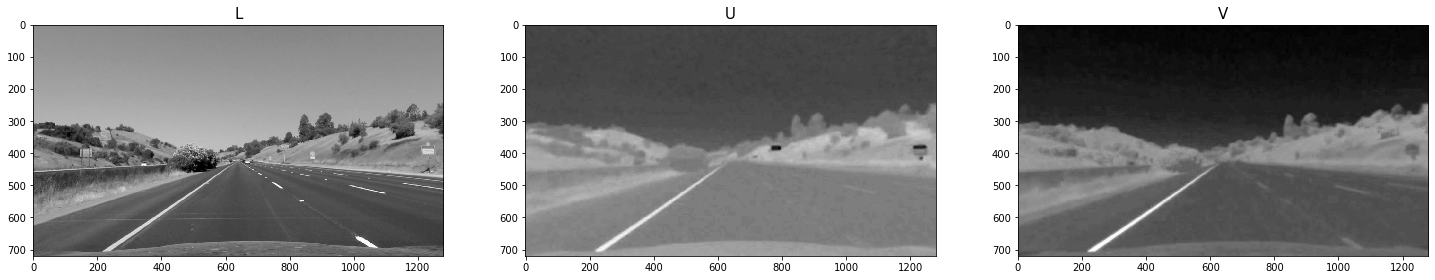

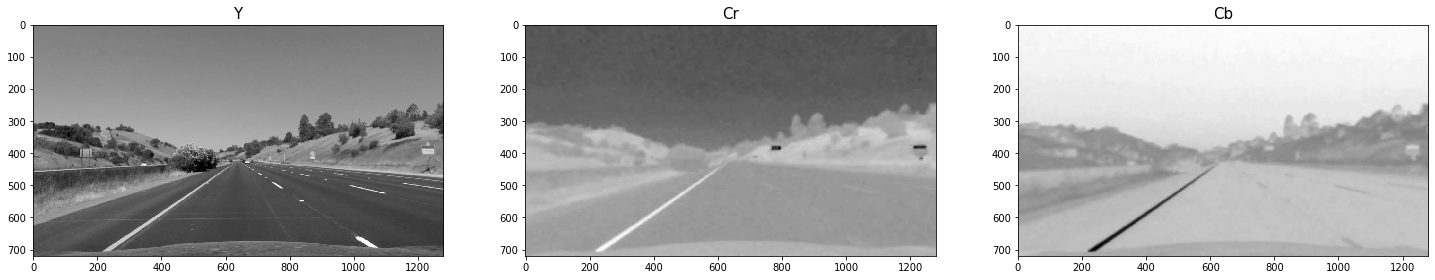

In [21]:
def darkenImage(image,gamma=1.0):
    gamma_inverse = 1.0 / gamma
    lut_table = np.array([((i / 255.0) ** gamma_inverse) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, lut_table)

# Change color space
# Split in to channels
r, g, b = cv2.split(undist)
dark_r = darkenImage(r, 0.7)
h_hsv, s_hsv, v_hsv = cv2.split(cv2.cvtColor(undist, cv2.COLOR_RGB2HSV))
h_hls, l_hls, s_hls = cv2.split(cv2.cvtColor(undist, cv2.COLOR_RGB2HLS))
l_lab, a_lab, b_lab = cv2.split(cv2.cvtColor(undist, cv2.COLOR_RGB2LAB))
l_luv, u_luv, v_luv = cv2.split(cv2.cvtColor(undist, cv2.COLOR_RGB2LUV))
y_ycrcb, cr_ycrcb, cb_ycrcb = cv2.split(cv2.cvtColor(undist, cv2.COLOR_RGB2YCrCb))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(dark_r,cmap='gray')
ax1.set_title('Darkened R', fontsize=15)
ax2.imshow(cv2.equalizeHist(r, 0.5),cmap='gray')
ax2.set_title('Equalized Histogram R', fontsize=15)
ax3.imshow(cv2.equalizeHist(s_hls, 0.5),cmap='gray')
ax3.set_title('Equalized Histogram S', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(r,cmap='gray')
ax1.set_title('R', fontsize=15)
ax2.imshow(g,cmap='gray')
ax2.set_title('G', fontsize=15)
ax3.imshow(b,cmap='gray')
ax3.set_title('B', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(h_hsv,cmap='gray')
ax1.set_title('H', fontsize=15)
ax2.imshow(s_hsv,cmap='gray')
ax2.set_title('S', fontsize=15)
ax3.imshow(v_hsv,cmap='gray')
ax3.set_title('V', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(h_hls,cmap='gray')
ax1.set_title('H', fontsize=15)
ax2.imshow(l_hls,cmap='gray')
ax2.set_title('L', fontsize=15)
ax3.imshow(s_hls,cmap='gray')
ax3.set_title('S', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(l_lab,cmap='gray')
ax1.set_title('L', fontsize=15)
ax2.imshow(a_lab,cmap='gray')
ax2.set_title('A', fontsize=15)
ax3.imshow(b_lab,cmap='gray')
ax3.set_title('B', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(l_luv,cmap='gray')
ax1.set_title('L', fontsize=15)
ax2.imshow(u_luv,cmap='gray')
ax2.set_title('U', fontsize=15)
ax3.imshow(v_luv,cmap='gray')
ax3.set_title('V', fontsize=15)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(y_ycrcb,cmap='gray')
ax1.set_title('Y', fontsize=15)
ax2.imshow(cr_ycrcb,cmap='gray')
ax2.set_title('Cr', fontsize=15)
ax3.imshow(cb_ycrcb,cmap='gray')
ax3.set_title('Cb', fontsize=15)
    

**3.2 Thresholds to Channels R(RGB),V(HSV),S(HLS)**

Text(0.5, 1.0, 'S Triangle')

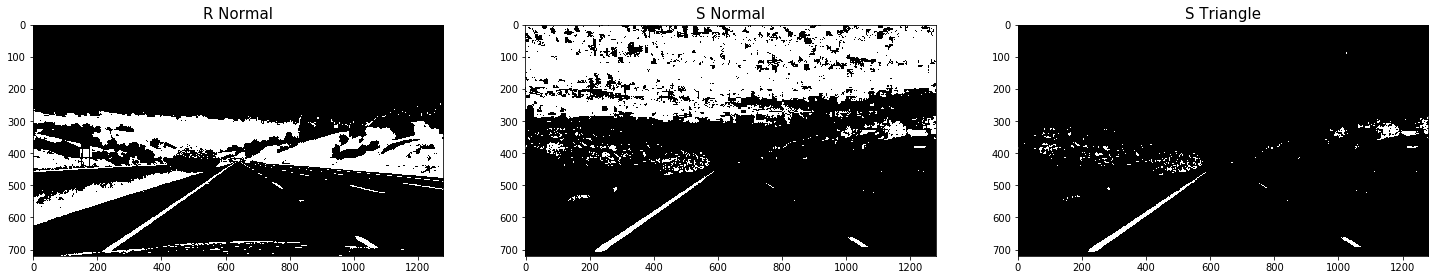

In [35]:
#thresholds
r_thres = (100, 255)
s_thres = (100, 255)

#Binary images
ret, binary_r = cv2.threshold(dark_r,100,1,cv2.THRESH_BINARY)
ret, binary_s = cv2.threshold(s_hls,100,1,cv2.THRESH_BINARY)
ret, s_binary_auto = cv2.threshold(s_hls,100,1,cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)        

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(binary_r,cmap='gray')
ax1.set_title('R Normal', fontsize=15)
ax2.imshow(binary_s,cmap='gray')
ax2.set_title('S Normal', fontsize=15)
ax3.imshow(s_binary_auto,cmap='gray')
ax3.set_title('S Triangle', fontsize=15)


**3.3 Gradients**

Text(0.5, 1.0, 'Combined')

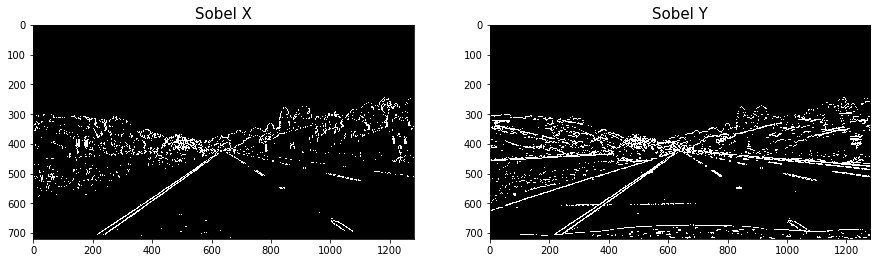

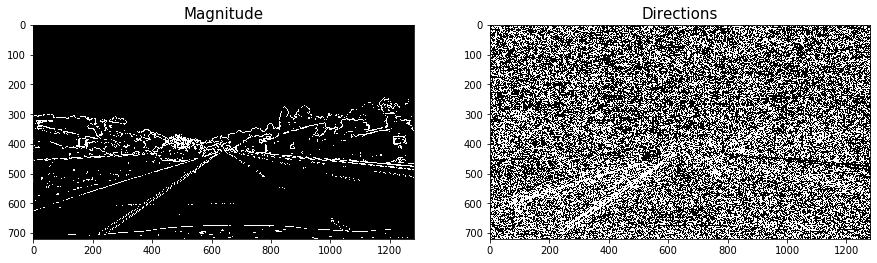

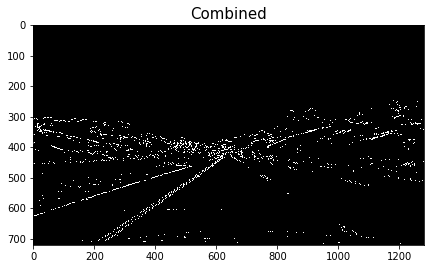

In [36]:
# Sobel x
sobelx = cv2.Sobel(dark_r, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 200
gradx = np.zeros_like(scaled_sobelx)
gradx[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1

# Sobel y
sobely = cv2.Sobel(dark_r, cv2.CV_64F, 0, 1) # Take the derivative in x
abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

# Threshold y gradient
thresh_min = 20
thresh_max = 200
grady = np.zeros_like(scaled_sobely)
grady[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1

#Magnitud of the Gradient
grad_mag = np.sqrt(sobelx**2+sobely**2)
scale_factor_mag = np.max(grad_mag)/255 
grad_mag = (grad_mag/scale_factor_mag).astype(np.uint8)

mag_thresh=(30, 100)
mag_binary = np.zeros_like(grad_mag)
mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1

#Direction of the Gradient
grad_dirct = np.arctan2(abs_sobely, abs_sobelx)

dir_thresh=(np.pi/4, 4*np.pi/9)
dir_binary = np.zeros_like(grad_dirct)
dir_binary[(grad_dirct >= dir_thresh[0]) & (grad_dirct <= dir_thresh[1])] = 1

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(gradx,cmap='gray')
ax1.set_title('Sobel X', fontsize=15)
ax2.imshow(grady,cmap='gray')
ax2.set_title('Sobel Y', fontsize=15)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mag_binary,cmap='gray')
ax1.set_title('Magnitude', fontsize=15)
ax2.imshow(dir_binary,cmap='gray')
ax2.set_title('Directions', fontsize=15)

plt.figure(figsize=(7,7))
plt.imshow(combined,cmap='gray')
plt.title("Combined", fontsize=15)



**3.4 Color and Gradient**

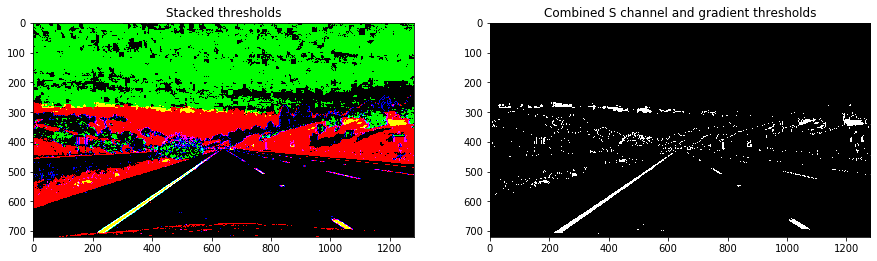

In [38]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((binary_r, binary_s, gradx)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(binary_r)
combined_binary[((binary_r == 1) & ((binary_s == 1) | (s_binary_auto == 1) | (gradx == 1)))] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')


### Step 4: Perspective transform (Bird's Eye)

Text(0.5, 1.0, 'Warped Binary Image')

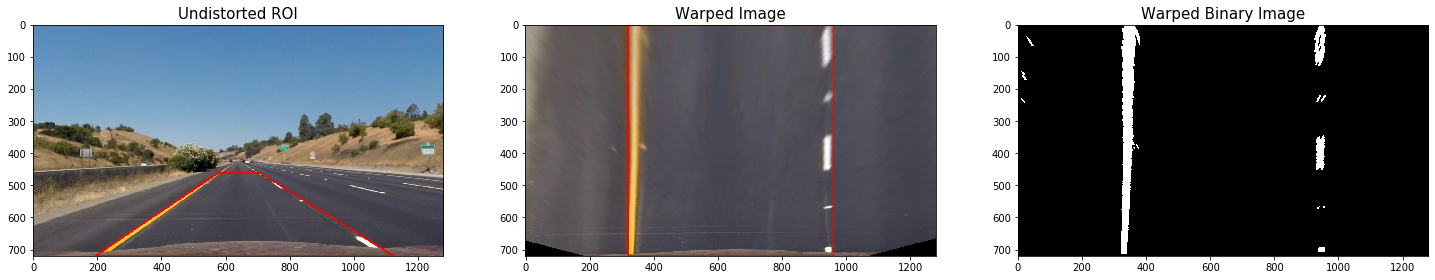

In [49]:
# define 4 source points
src_points = [(193,720), (577,460),(705,460),(1126,720)]

# define 4 destination points
dst_points = [(320,720), (320,0)  ,(960,0)  ,(960,720)]

undist_roi = undist.copy()
cv2.polylines(undist_roi,np.array([src_points],dtype=np.int32),True,(255,0,0),4)

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(np.float32(src_points), np.float32(dst_points))

# Warp the image 
warped = cv2.warpPerspective(undist, M, img_size)
rgb_warp = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
warped_binary = cv2.warpPerspective(combined_binary, M, img_size)

warped_roi = warped.copy()
cv2.polylines(warped_roi,np.array([dst_points],dtype=np.int32),True,(255,0,0),4)

warped_binary = cv2.morphologyEx(warped_binary, cv2.MORPH_OPEN, np.ones((3,3)))
warped_binary = cv2.morphologyEx(warped_binary, cv2.MORPH_TOPHAT, np.ones((2,65)))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,25))
ax1.imshow(undist_roi)
ax1.set_title('Undistorted ROI', fontsize=15)
ax2.imshow(warped_roi)
ax2.set_title('Warped Image', fontsize=15)
ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Warped Binary Image', fontsize=15)


### Step 5: Detect lane lines

**5.1 Compute Histogram and Locate Lane Lines**

Take the bottom half of the image to compute the histogram, thus, the lane lines are more vertical.

Compute the histogram, the peaks will be regions with more probability to be a lane line.

Divide the histogram in to equal parts and get the maximum peak of each side. The peaks are the first position of the left and right lines.

329 945


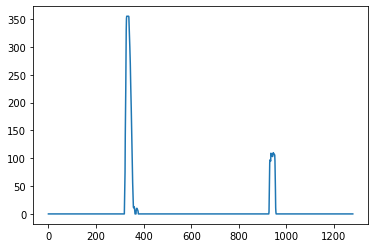

In [40]:
# Take a histogram of the bottom half of the image
# Lane lines are likely to be mostly vertical nearest to the car
histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base,rightx_base)
plt.plot(histogram)



Updated version using bins to agroup cols of pixels

340 940


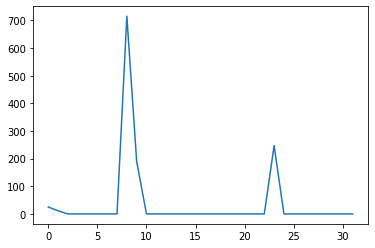

In [41]:
pix_per_bin = 40
windows = warped_binary.shape[1]//pix_per_bin
hist = []
for window in range(windows):
    w_low = window * pix_per_bin
    w_high = (window +1) * pix_per_bin
    hist.append(np.max(np.sum(warped_binary[:,w_low:w_high], axis=0)))

#print(hist)
hist = np.array(hist)
plt.plot(hist)

leftx_base = (np.argmax(hist[:windows//2]) * pix_per_bin) + pix_per_bin//2
rightx_base = (np.argmax(hist[windows//2:]) + warped_binary.shape[1]//pix_per_bin//2) * pix_per_bin + pix_per_bin//2
print(leftx_base,rightx_base)



**5.2 Sliding Windows and Fit a Polynomial**

As shown in the previous animation, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

340 940


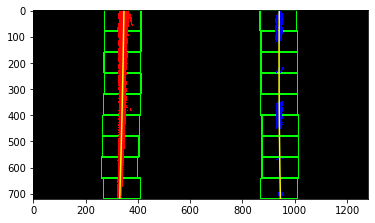

In [42]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 70
# Set minimum number of pixels found to recenter window
minpix = 300

# Create an output image to draw on and visualize the result
out_img = np.dstack((warped_binary, warped_binary, warped_binary))
    
# Set height of windows - based on nwindows above and image shape
window_height = np.int(warped_binary.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = warped_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

print(leftx_current,rightx_current)
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low  = warped_binary.shape[0] - (window+1)*window_height
    win_y_high = warped_binary.shape[0] - window*window_height
    
    # Find the four below boundaries of the window ###
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
    (win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
    (win_xright_high,win_y_high),(0,255,0), 3) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window
    if good_left_inds.shape[0] > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if good_right_inds.shape[0] > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    

# Concatenate the arrays of indices (previously was a list of lists of pixels)
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each line
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

**5.3 Search from Prior**

Using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame.

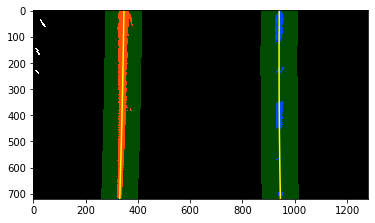

In [43]:
# HYPERPARAMETER
# Choose the width of the margin around the previous polynomial to search
# The quiz grader expects 100 here, but feel free to tune on your own!
margin = 70

# Grab activated pixels
nonzero = warped_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set the area of search based on activated x-values
# within the +/- margin of our polynomial function
left_lane_inds  = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) &
                   (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                        left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                        right_fit[2] - margin)) &
                   (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                        right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each line
left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])

# Calc both polynomials
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]

## Visualization ##
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                          ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                          ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
## End visualization steps ##

plt.imshow(result)

### Step 6: Determine the lane curvature

**6.1 Radius of Curvature**

The radius of curvature <A HREF="https://www.intmath.com/applications-differentiation/8-radius-curvature.php" target="_blank">(awesome tutorial)</A> at any point $x$ of the function $x = f(y)$, where $f(y)$ is a second order polynomial, is given as follows:

$$R_{curve} = \frac{(1+(2Ay+B)^{2})^{3/2}}{|2A|}$$

Where:

$$ f'(y) = \frac{dx}{dy} = 2Ay + B  $$
$$ f''(y) = \frac{d^2 x}{d^2 y} = 2A  $$

In [44]:
# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of radius of curvature
# y = axÂ² + bx + c; y'=2ax + b; y''= 2a

left_curverad  = ((1+(2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)) / np.absolute(2*left_fit[0])
right_curverad = ((1+(2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

38708.19006022488 27317.184963388565


**6.2 From Pixels to Real-World**

We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide.

Let's say that the camera image has 720 relevant pixels in the y-dimension (remember, the image is perspective-transformed!), and we'll say roughly 700 relevant pixels in the x-dimension.

Once the parameters of the parabole ($x = ay^2 + by + c$) are calculated, this formula can convert the coeficients from pixels to meters:
$$ x = \frac {mx}{my^2} ay^2 + \frac{mx}{my}by + c$$


In [45]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

y_eval = y_eval * ym_per_pix

# Calculation of radius of curvature in meters
A = (xm_per_pix / (ym_per_pix ** 2))* left_fit[0]
B = (xm_per_pix / ym_per_pix) * left_fit[1]
left_curverad  = ((1+(2*A + B)**2)**(3/2)) / np.absolute(2*A)

A = (xm_per_pix / (ym_per_pix ** 2))* right_fit[0]
B = (xm_per_pix / ym_per_pix) * right_fit[1]
right_curverad  = ((1+(2*A + B)**2)**(3/2)) / np.absolute(2*A)

mean_curvature = (left_curverad + right_curverad)/2

curvature_string = "Radius of curvature: %.2f km" % (abs(mean_curvature)/1000.0)
print(curvature_string)

Radius of curvature: 10.83 km


**6.3 Car lane center offset**

In [46]:
lane_center = (rightx[719] + leftx[719])/2
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Center offset: 0.01 m


### Plot Everythig together

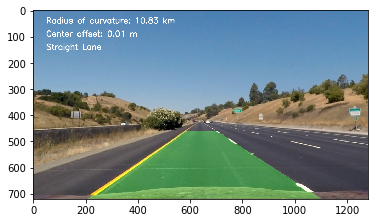

In [47]:
warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
M = cv2.getPerspectiveTransform(np.float32(dst_points), np.float32(src_points))
newwarp = cv2.warpPerspective(color_warp, M,(color_warp.shape[1],color_warp.shape[0]))
# Combine the result with the original image
final = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


if (abs(mean_curvature) >= 5000):
    lane_string = "Straight Lane"
elif (mean_curvature >= 0 and mean_curvature < 5000):
    lane_string = "Right Curve"
elif (mean_curvature < 0 and mean_curvature > -5000):
    lane_string = "Left Curve"

cv2.putText(final,curvature_string,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(final,offset_string,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(final,lane_string,(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
            

plt.imshow(final)